# Customer Segmentation Using Machine Learning

***Importing Libraries***

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
!pip install openpyxl

In [8]:
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, \
Birch, DBSCAN, MiniBatchKMeans, MeanShift, OPTICS, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

***Functions & Constants***

In [10]:
def one_hot_encoder(dataframe, encoding_col_list):
    ohe= OneHotEncoder()
    dummies = ohe.fit_transform(dataframe[encoding_col_list]).toarray()
    feature_names = ohe.get_feature_names_out(encoding_col_list)
    dummies_df = pd.DataFrame(dummies,columns=feature_names).astype(int)

    dataframe_enc = pd.concat([dataframe, dummies_df], axis=1, join='inner')

    dataframe_enc.drop(encoding_col_list,axis=1, inplace=True)
    return dataframe_enc

# Elbow method to determne the optimum number of Clusters
def elbow(dataframe, l_range, h_range):
    distortions = []
    for i in range(l_range, h_range):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=100, random_state=0
        )
        km.fit(dataframe)
        distortions.append(km.inertia_)

    # plot
    plt.plot(range(l_range, h_range), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    
#Elbow Method with Yellowbrick Library
def elbow_auto(dataframe):
    model = KMeans(init='k-means++',
                n_init=10, max_iter=100, random_state=0)
    visualizer = KElbowVisualizer(model, k=10)

    visualizer.fit(dataframe)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
    
    
#Using Silhoutte Score to determine the optimum number of Clusters
def silhoutte(dataframe, l_range, h_range):
    for i in range(l_range, h_range):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=100, random_state=0
        )
        km.fit(dataframe)
        cluster_labels = km.labels_

        silhouette_avg = silhouette_score(dataframe, cluster_labels)
        print(f" For {i} clusters, SilhoutteScore is: {silhouette_avg}")
        

#Silhoutte Score method using Yellwbrick library
def silhoutte_auto(dataframe, l_range, h_range):
    model = KMeans(init='k-means++',n_init=10, max_iter=100, random_state=0)
    visualizer = KElbowVisualizer(model, k=(l_range,h_range), metric='silhouette')

    visualizer.fit(dataframe)
    visualizer.show()
    plt.show()

***Load Data***

In [13]:
df = pd.read_csv("new.csv", delimiter=",") 
df.head()


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

***Data Description***

In [15]:
print(len(df))
print(len(df.columns))

2240
29


In [16]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

***Missing Values***

In [18]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [19]:
df.dropna(axis= 0, inplace=True)
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [20]:
df.nunique()


ID                     2216
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             662
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         554
MntFishProducts         182
MntSweetProducts        176
MntGoldProds            212
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

In [23]:
df.drop(["Z_CostContact", "Z_Revenue"], axis=1 , inplace=True)

In [31]:
plot_cols= [c for c in df.columns if df[c].nunique()<20]
plot_cols

['Education',
 'Marital_Status',
 'Kidhome',
 'Teenhome',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response']

In [33]:
for c in plot_cols:
    fig= px.histogram(df, x=c, text_auto= True)
    fig.show()
    

***Feature Engineering***

In [35]:
# Convert date to date object with the correct format
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y", dayfirst=True)

In [36]:
#Convert date to date object
df["Dt_Customer"]= pd.to_datetime(df["Dt_Customer"])

#Create Month and Year variables from Dt_Customer
df["Customer_year"]= df["Dt_Customer"].dt.year
df["Customer_month"]= df["Dt_Customer"].dt.month

#Removing ID, Date from further analysis
df.drop(["ID","Dt_Customer"], axis= 1, inplace=True)
df.head()

Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  Recency  \
0        1957  Graduation         Single  58138.0        0         0       58   
1        1954  Graduation         Single  46344.0        1         1       38   
2        1965  Graduation       Together  71613.0        0         0       26   
3        1984  Graduation       Together  26646.0        1         0       26   
4        1981         PhD        Married  58293.0        1         0       94   

   MntWines  MntFruits  MntMeatProducts  ...  NumWebVisitsMonth  AcceptedCmp3  \
0       635         88              546  ...                  7             0   
1        11          1                6  ...                  5             0   
2       426         49              127  ...                  4             0   
3        11          4               20  ...                  6             0   
4       173         43              118  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0             0             0             0             0         0         1   
1             0             0             0             0         0         0   
2             0             0             0             0         0         0   
3             0             0             0             0         0         0   
4             0             0             0             0         0         0   

   Customer_year  Customer_month  
0           2012               9  
1           2014               3  
2           2013               8  
3           2014               2  
4           2014               1  

[5 rows x 27 columns]

In [37]:
# Update the column and assign back explicitly
df["Marital_Status"] = df["Marital_Status"].replace(["Alone", "Absurd", "YOLO"], "Single")

# Create a copy of the DataFrame
df_enc = df.copy()


In [38]:
#df_enc = one_hot_encoder(df, encoding_col_list= ["Education","Marital_Status"])
le= LabelEncoder()
enc_cols= ["Education","Marital_Status"]
for c in enc_cols:
    df_enc[c]= le.fit_transform(df_enc[c])

In [39]:
len(df_enc)

2216

In [46]:
df_enc.head()

Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  Recency  \
0        1957          2               2  58138.0        0         0       58   
1        1954          2               2  46344.0        1         1       38   
2        1965          2               3  71613.0        0         0       26   
3        1984          2               3  26646.0        1         0       26   
4        1981          4               1  58293.0        1         0       94   

   MntWines  MntFruits  MntMeatProducts  ...  NumWebVisitsMonth  AcceptedCmp3  \
0       635         88              546  ...                  7             0   
1        11          1                6  ...                  5             0   
2       426         49              127  ...                  4             0   
3        11          4               20  ...                  6             0   
4       173         43              118  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0             0             0             0             0         0         1   
1             0             0             0             0         0         0   
2             0             0             0             0         0         0   
3             0             0             0             0         0         0   
4             0             0             0             0         0         0   

   Customer_year  Customer_month  
0           2012               9  
1           2014               3  
2           2013               8  
3           2014               2  
4           2014               1  

[5 rows x 27 columns]

***Feature Scaling***

In [49]:
scaler= MinMaxScaler()
scaled = scaler.fit_transform(df_enc)
df_enc_scaled= pd.DataFrame(scaled, columns= df_enc.columns)
df_enc_scaled.head()

Year_Birth  Education  Marital_Status    Income  Kidhome  Teenhome  \
0    0.621359        0.5            0.50  0.084832      0.0       0.0   
1    0.592233        0.5            0.50  0.067095      0.5       0.5   
2    0.699029        0.5            0.75  0.105097      0.0       0.0   
3    0.883495        0.5            0.75  0.037471      0.5       0.0   
4    0.854369        1.0            0.25  0.085065      0.5       0.0   

    Recency  MntWines  MntFruits  MntMeatProducts  ...  NumWebVisitsMonth  \
0  0.585859  0.425318   0.442211         0.316522  ...               0.35   
1  0.383838  0.007368   0.005025         0.003478  ...               0.25   
2  0.262626  0.285332   0.246231         0.073623  ...               0.20   
3  0.262626  0.007368   0.020101         0.011594  ...               0.30   
4  0.949495  0.115874   0.216080         0.068406  ...               0.25   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   Complain  Response  Customer_year  Customer_month  
0       0.0       1.0            0.0        0.727273  
1       0.0       0.0            1.0        0.181818  
2       0.0       0.0            0.5        0.636364  
3       0.0       0.0            1.0        0.090909  
4       0.0       0.0            1.0        0.000000  

[5 rows x 27 columns]

### Identifying the Number of Clusters


***Elbow Method***

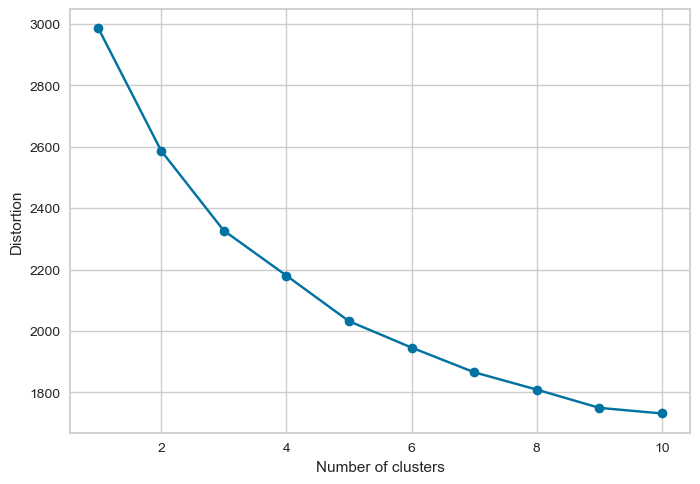

In [53]:
elbow(df_enc_scaled, 1, 11)

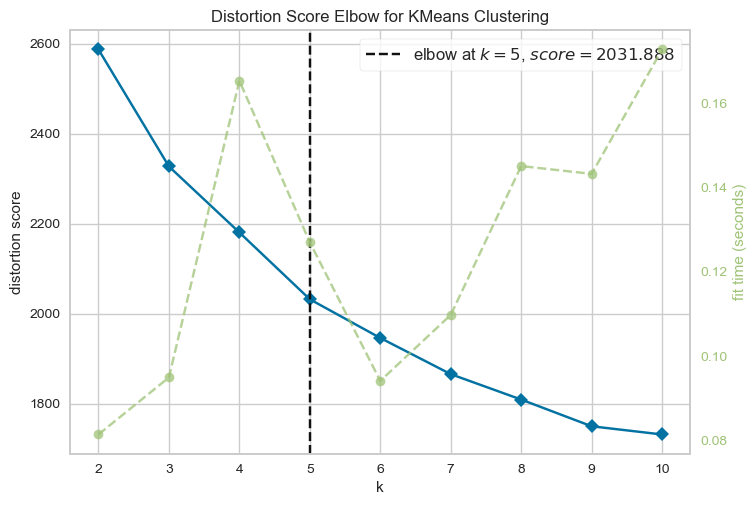

In [54]:
elbow_auto(df_enc_scaled)

***Silhoutte Method***

In [57]:
silhoutte(df_enc_scaled, 2, 11)

 For 2 clusters, SilhoutteScore is: 0.15812261644558528
 For 3 clusters, SilhoutteScore is: 0.14040907071108513
 For 4 clusters, SilhoutteScore is: 0.14312599930816935
 For 5 clusters, SilhoutteScore is: 0.10857060102238095
 For 6 clusters, SilhoutteScore is: 0.11830492368261358
 For 7 clusters, SilhoutteScore is: 0.11250826388352156
 For 8 clusters, SilhoutteScore is: 0.10601482262556138
 For 9 clusters, SilhoutteScore is: 0.10834773346315445
 For 10 clusters, SilhoutteScore is: 0.11458226813186141


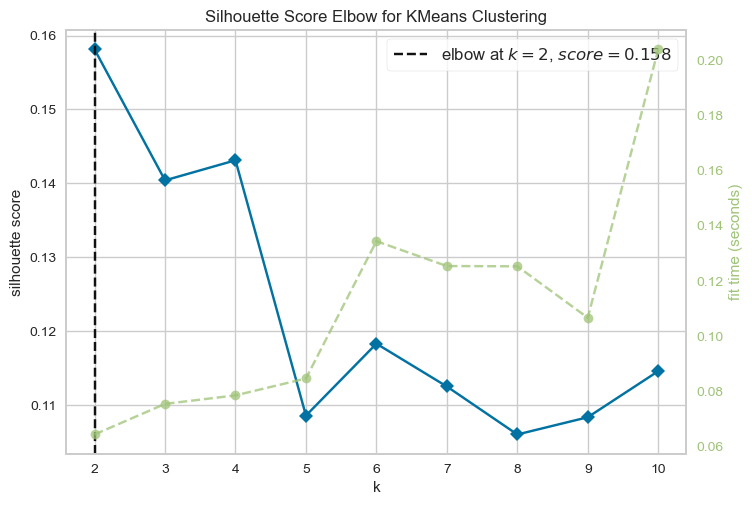

In [58]:
silhoutte_auto(df_enc_scaled, 2, 11)

### K Means Clustering without Dimensionality Reduction

In [62]:
km= KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)
km.fit(df_enc_scaled)
df["cluster_km_orig"] = km.labels_

In [65]:
# Silhoutte Score
sc= silhouette_score(df_enc_scaled, km.labels_)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.14040907071108513


***Dimensionality Reduction: PCA***

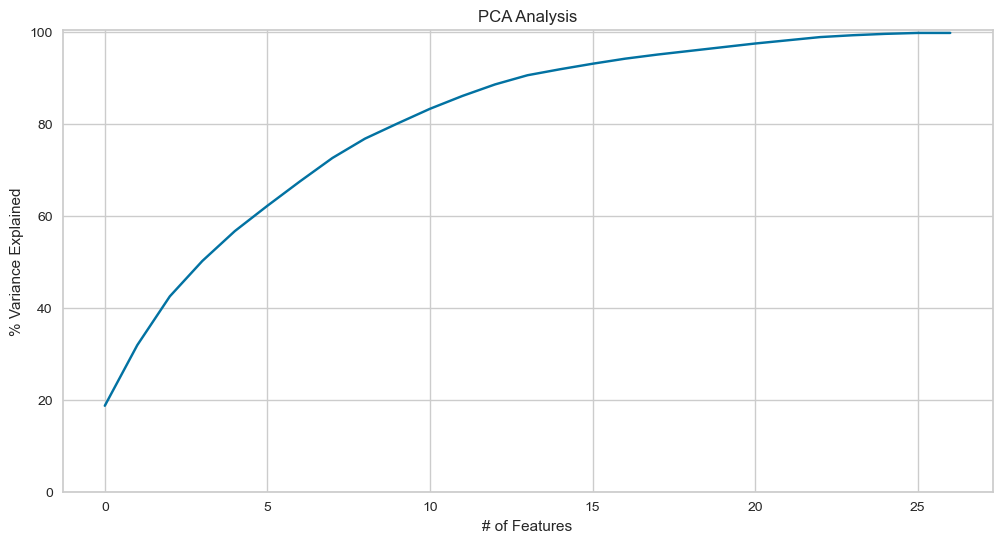

In [68]:
pca = PCA(n_components= len(df_enc_scaled.columns))
pca.fit(df_enc_scaled)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [70]:
var

array([18.7, 31.9, 42.5, 50.2, 56.7, 62.2, 67.5, 72.6, 76.8, 80.1, 83.3,
       86.1, 88.6, 90.6, 91.9, 93.1, 94.2, 95.1, 95.9, 96.7, 97.5, 98.2,
       98.9, 99.3, 99.6, 99.8, 99.8])

In [72]:
pca = PCA(n_components=3)
pca.fit(df_enc_scaled)
PCA_df = pd.DataFrame(pca.transform(df_enc_scaled), columns=(["col1","col2", "col3"]))
PCA_df.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2216.0 -4.529069e-17  0.502354 -0.844874 -0.410543 -0.084718  0.294509   
col2  2216.0  6.573162e-17  0.422248 -0.865225 -0.328650  0.006094  0.345697   
col3  2216.0  4.088186e-17  0.378051 -0.792269 -0.281047 -0.032416  0.183800   

           max  
col1  1.762932  
col2  1.044625  
col3  1.328991

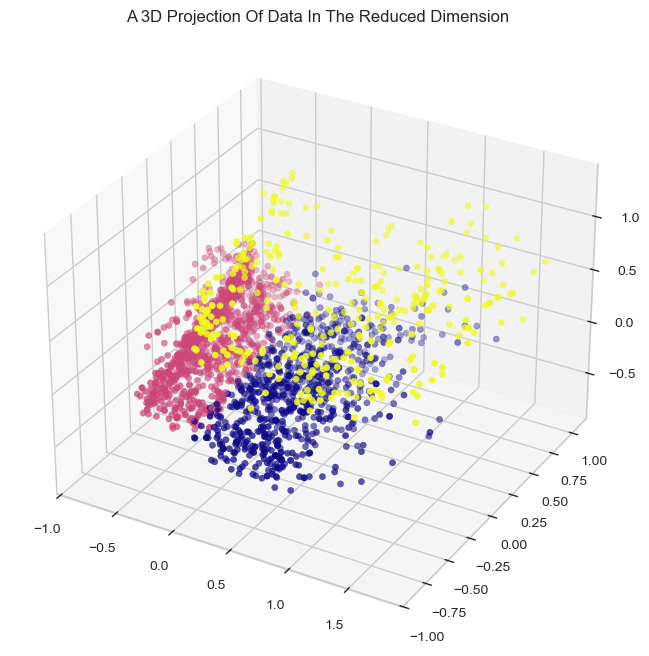

In [74]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_df["col1"]
y =PCA_df["col2"]
z =PCA_df["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c= km.labels_, marker="o" , cmap="plasma")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

***KMeans Clustering after PCA***

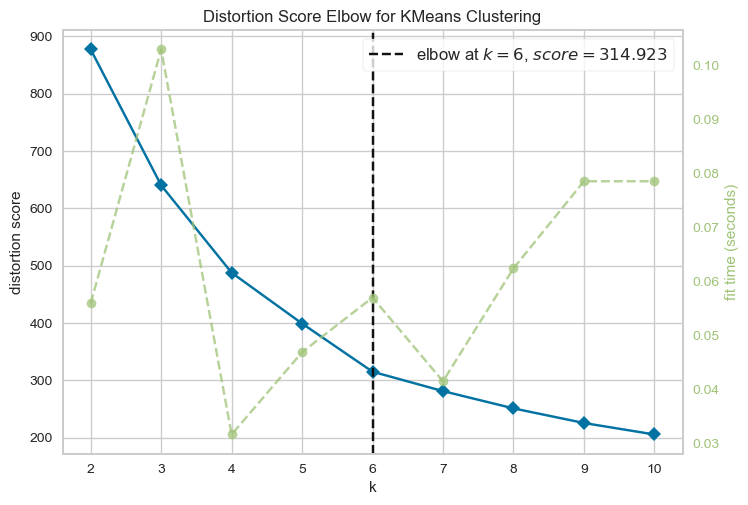

In [77]:
elbow_auto(PCA_df)

In [78]:
silhoutte(PCA_df,2,11)

 For 2 clusters, SilhoutteScore is: 0.3244426402020535
 For 3 clusters, SilhoutteScore is: 0.34657853752479645
 For 4 clusters, SilhoutteScore is: 0.3443920948275291
 For 5 clusters, SilhoutteScore is: 0.34531388575169825
 For 6 clusters, SilhoutteScore is: 0.37220247450565075
 For 7 clusters, SilhoutteScore is: 0.3765394046629645
 For 8 clusters, SilhoutteScore is: 0.3457029706053243
 For 9 clusters, SilhoutteScore is: 0.3567921886847117
 For 10 clusters, SilhoutteScore is: 0.36162613452674247


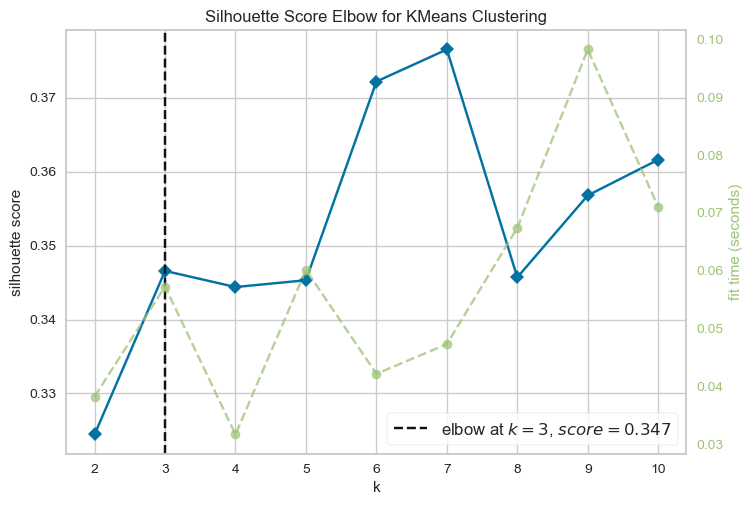

In [80]:
silhoutte_auto(PCA_df,2,11)

In [81]:
km= KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)
ypred= km.fit_predict(PCA_df)
PCA_df["cluster_km_pca"] = ypred
#Adding the Clusters feature to the orignal dataframe.
df["cluster_km_pca"] = km.labels_

labels_pca_scale = km.labels_

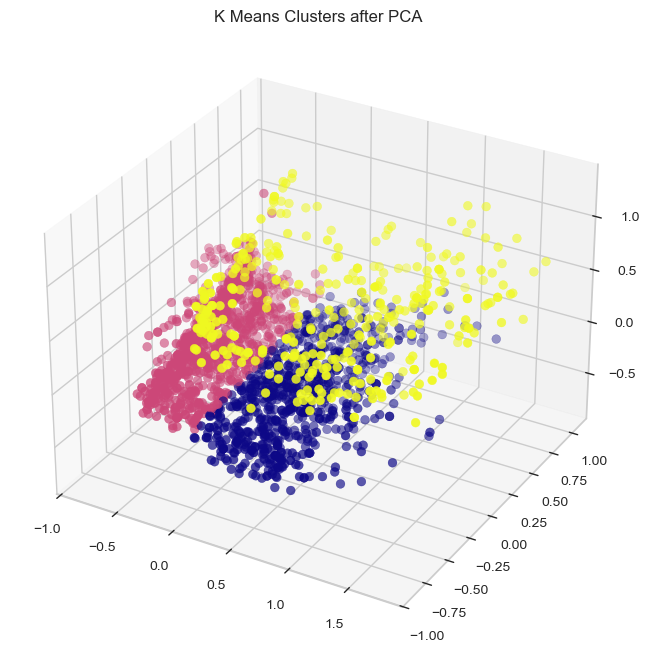

In [83]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x,y,z, s=40, c= km.labels_, marker='o' ,cmap = 'plasma' )
ax.set_title("K Means Clusters after PCA")
plt.show()

In [87]:
# Silhoutte Score
sc= silhouette_score(PCA_df, km.labels_)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5523449893075018


***t-SNE***

In [90]:
from sklearn.manifold import TSNE
import pandas as pd

# Configure and fit TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=30, max_iter=250, learning_rate=200)
tsne_scale_results = tsne.fit_transform(df_enc_scaled)

# Create a DataFrame from TSNE results
tsne_df = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2216 samples in 0.001s...
[t-SNE] Computed neighbors for 2216 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2216
[t-SNE] Computed conditional probabilities for sample 2000 / 2216
[t-SNE] Computed conditional probabilities for sample 2216 / 2216
[t-SNE] Mean sigma: 0.346805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.279900
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


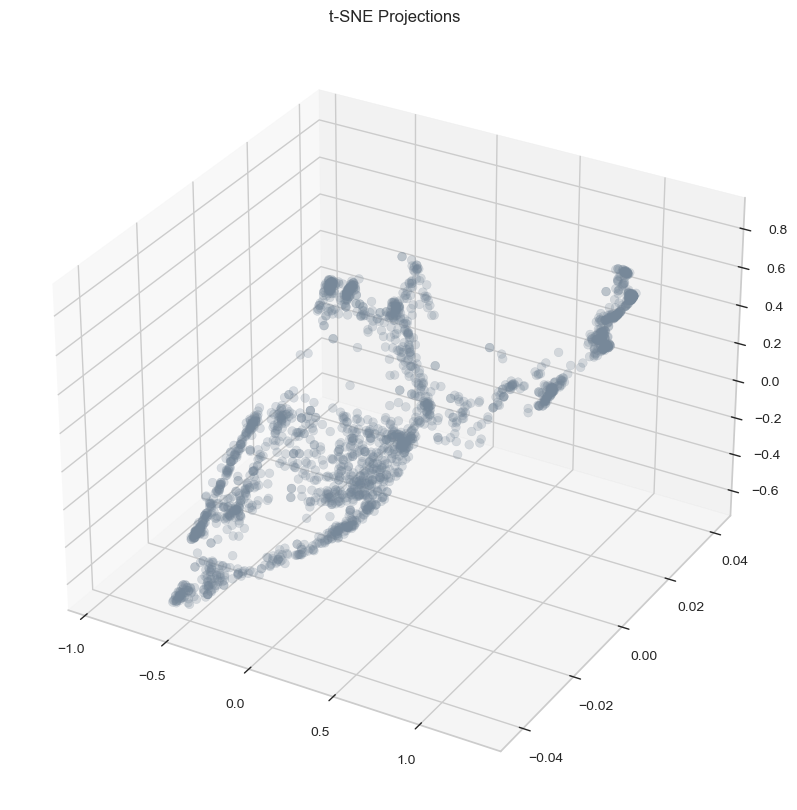

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract t-SNE projections
tx = tsne_df.iloc[:, 0]
ty = tsne_df.iloc[:, 1]
tz = tsne_df.iloc[:, 2]

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='3d')
ax.scatter(tx, ty, tz, s=40, alpha=0.25, facecolor='lightslategray', marker='o')
ax.set_title("t-SNE Projections")
plt.show()


***KMeans Clustering after t-SNE***

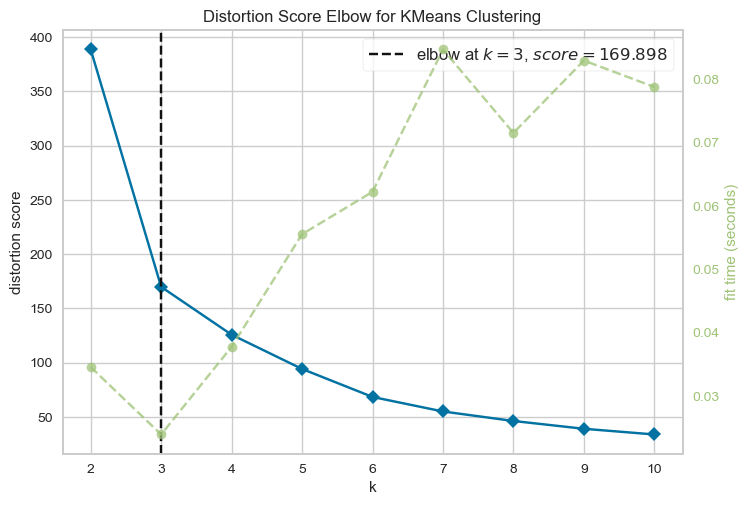

In [93]:
elbow_auto(tsne_df)

In [94]:
silhoutte(tsne_df,2,11)

 For 2 clusters, SilhoutteScore is: 0.6549151539802551
 For 3 clusters, SilhoutteScore is: 0.5830985307693481
 For 4 clusters, SilhoutteScore is: 0.574832558631897
 For 5 clusters, SilhoutteScore is: 0.5666826367378235
 For 6 clusters, SilhoutteScore is: 0.5702618360519409
 For 7 clusters, SilhoutteScore is: 0.5308285355567932
 For 8 clusters, SilhoutteScore is: 0.5015664100646973
 For 9 clusters, SilhoutteScore is: 0.5250636339187622
 For 10 clusters, SilhoutteScore is: 0.5084763765335083


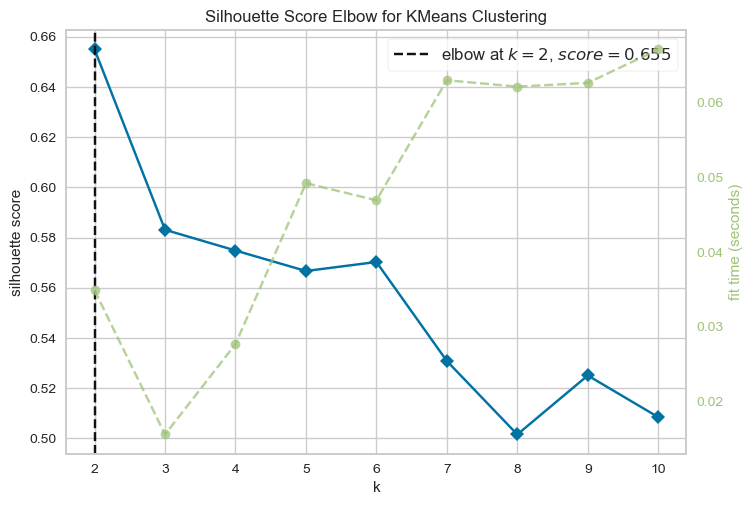

In [95]:
silhoutte_auto(tsne_df,2,11)

In [96]:
km= KMeans(n_clusters=3, init='k-means++',
            n_init=10, max_iter=100, random_state=0)
ypred= km.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_km_tsne"] = km.labels_

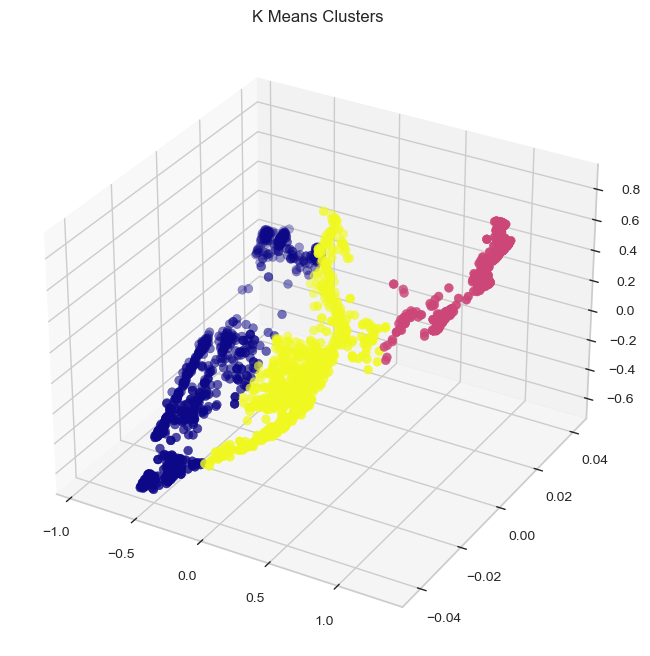

In [97]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(tx,ty,tz, s=40, c=km.labels_, marker='o' ,cmap = 'plasma' )
ax.set_title("K Means Clusters")
plt.show()

In [98]:
# Silhoutte Score
sc= silhouette_score(tsne_df, km.labels_)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5830985307693481


***2. Mini-Batch K Means***

In [100]:
#Initiating the MiniBatchKMeans Clustering model 
MP = MiniBatchKMeans(n_clusters=3)
# fit model and predict clusters
MP_df = MP.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_mini"]= MP_df

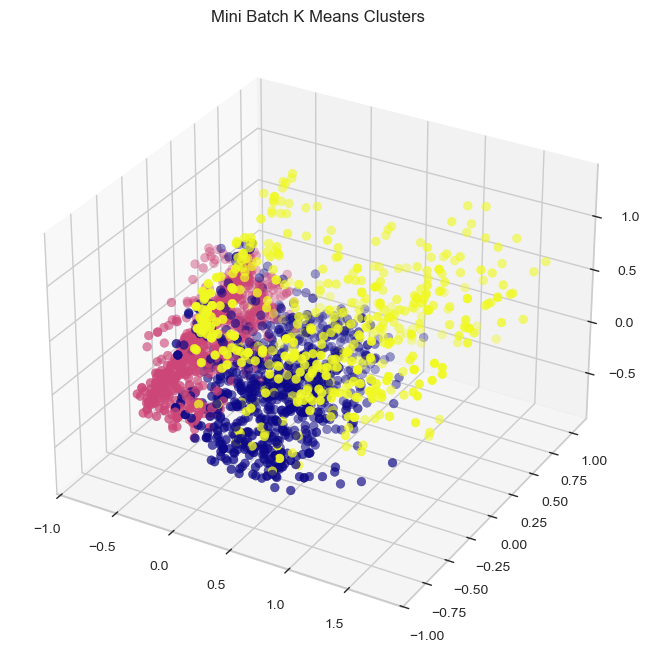

In [107]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=df["cluster_mini"], marker='o', cmap = 'plasma' )
ax.set_title("Mini Batch K Means Clusters")
plt.show()

In [108]:
# Silhoutte Score
sc= silhouette_score(tsne_df, MP_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5831180214881897


***3. Agglomerative Clustering***

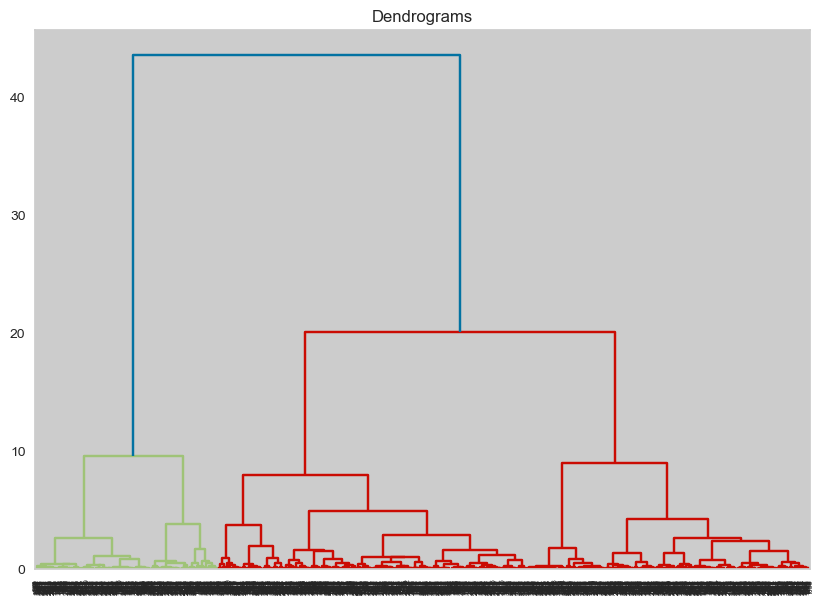

In [113]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(tsne_df, method='ward'))

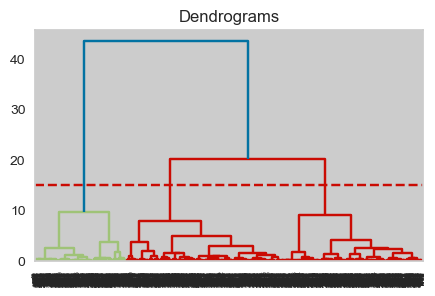

In [116]:
plt.figure(figsize=(5, 3))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(tsne_df, method='ward'))
plt.axhline(y=15, color='r', linestyle='--')

**Using Scikit Learn**

In [120]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat_AC = AC.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_agglo"]= yhat_AC

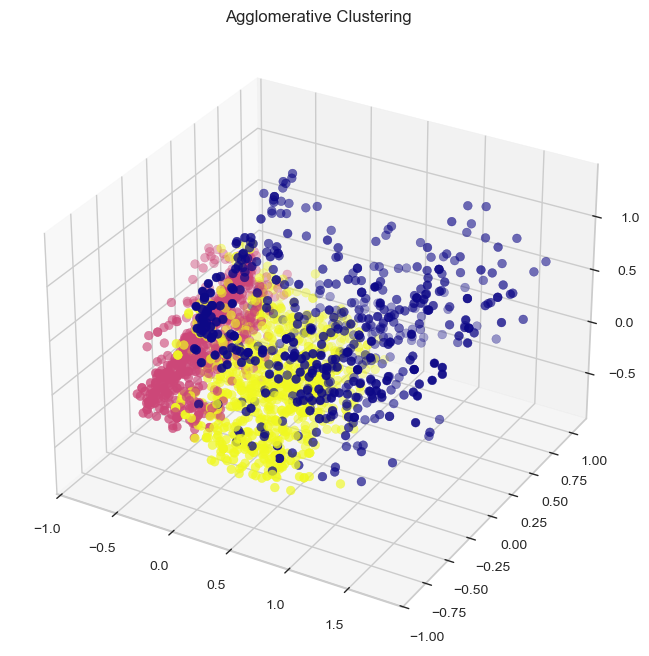

In [121]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= yhat_AC, marker='o', cmap = 'plasma' )
ax.set_title("Agglomerative Clustering")
plt.show()

In [122]:
# Silhoutte Score
sc= silhouette_score(tsne_df, yhat_AC)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5623952150344849


***4. DBSCAN***

**Finding optimal hyperparameters**

In [125]:
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(tsne_df) # fitting the data to the object
distances,indices=nbrs.kneighbors(tsne_df) # finding the nearest neighbours

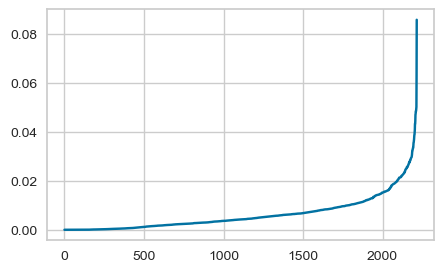

In [126]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

***Sklearn DBSCAN model***

In [128]:
#Initiating the DBSCAN Clustering model 
DB = DBSCAN(eps=0.4, min_samples=250, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
# fit model and predict clusters
DB_df = DB.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_dbscan"]= DB_df

In [129]:
np.unique(DB_df)

array([0, 1], dtype=int64)

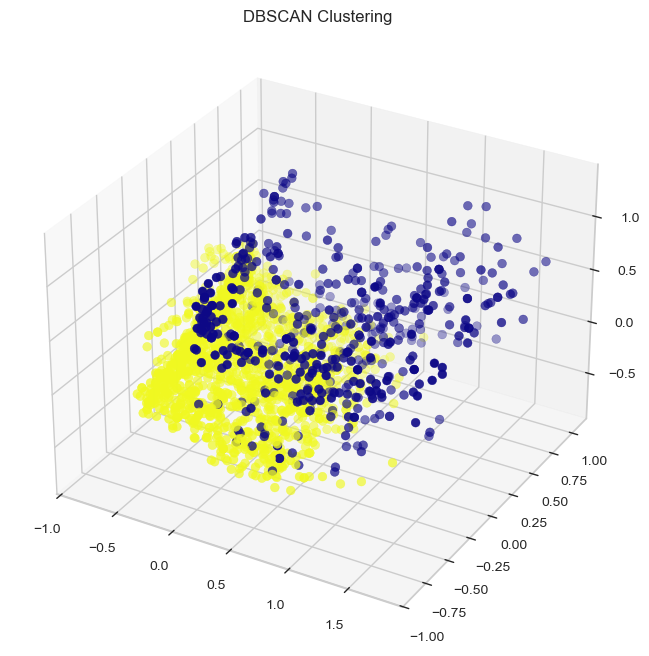

In [130]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= DB_df, marker='o', cmap = 'plasma' )
ax.set_title("DBSCAN Clustering")
plt.show()

In [131]:
# Silhoutte Score
sc= silhouette_score(tsne_df, DB_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.6590833067893982


***5. OPTICS***

In [133]:
#Initiating the OPTICS Clustering model 
OP = OPTICS(eps=0.4, min_samples=250)
# fit model and predict clusters
OP_df = OP.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_optics"]= OP_df

In [134]:
np.unique(OP_df)

array([-1,  0,  1])

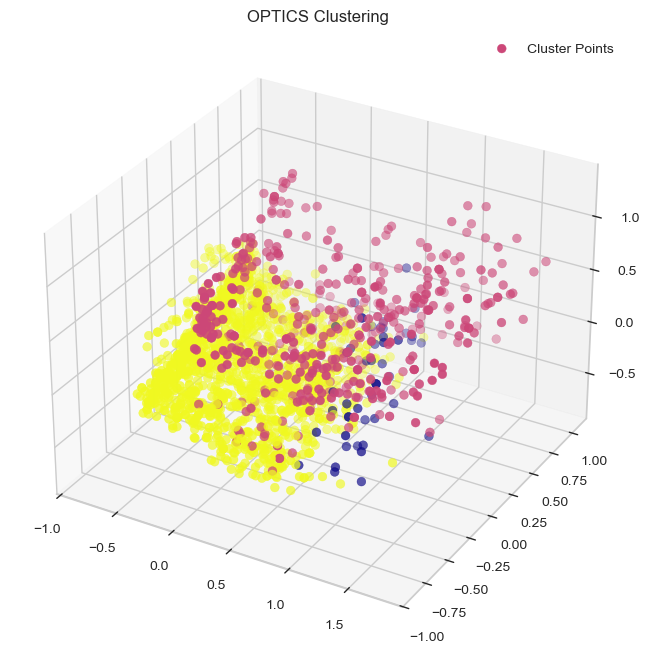

In [135]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
scatter = ax.scatter(x, y, z, s=40, c=OP_df, marker='o', cmap='plasma', label="Cluster Points")
ax.legend()
ax.set_title("OPTICS Clustering")
plt.show()



In [136]:
# Silhoutte Score
sc= silhouette_score(tsne_df, OP_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.4211294651031494


***BIRCH***

In [138]:
#Initiating the Birch Clustering model 
BP = Birch(threshold=0.5, n_clusters=3)
# fit model and predict clusters
BP_df = BP.fit_predict(tsne_df)
#Adding the Clusters feature to the orignal dataframe.
df["cluster_birch"]= BP_df

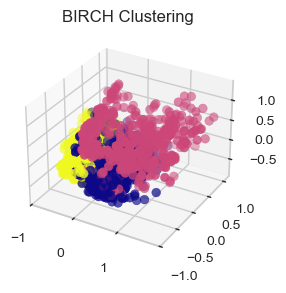

In [139]:

ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=BP_df, marker='o', cmap='plasma')
ax.set_title("BIRCH Clustering")
plt.show()


In [140]:
# Silhoutte Score
sc= silhouette_score(tsne_df, BP_df)
print (f"Silhoutte Score is: {sc}")

Silhoutte Score is: 0.5830300450325012


***Evaluation of Clusters***

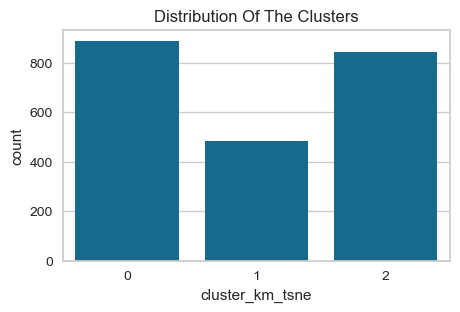

In [142]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["cluster_km_tsne"])
pl.set_title("Distribution Of The Clusters")
plt.show()

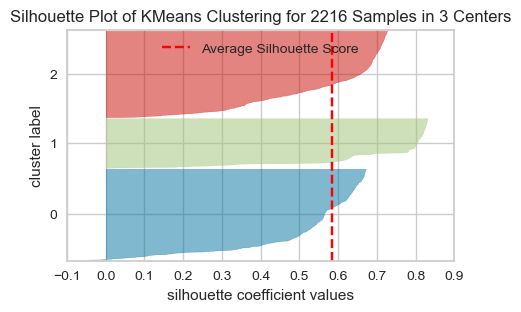

In [143]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=3, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(tsne_df)
visualizer.show()
plt.show()

In [144]:
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ \
df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

***Univariate Analysis***

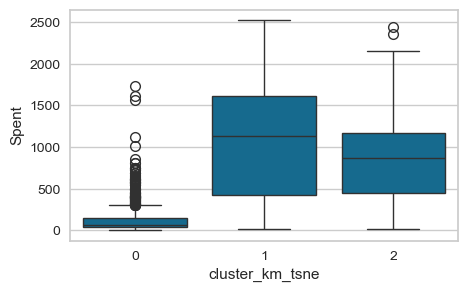

In [146]:
ppl = sns.boxplot(data=df, x=df["cluster_km_tsne"], y=df["Spent"])
pl.set_title("Cluster Profiles Based On Spending")
plt.show()


In [147]:
#Removing one outlier point on Income
df= df[df["Income"]<500000]

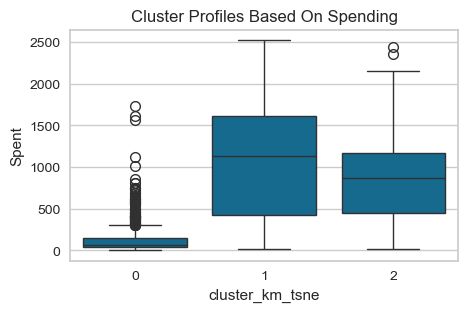

In [148]:
pl = sns.boxplot(data=df, x=df["cluster_km_tsne"], y=df["Spent"])
pl.set_title("Cluster Profiles Based On Spending")
plt.show()


***Bivariate Analysis***

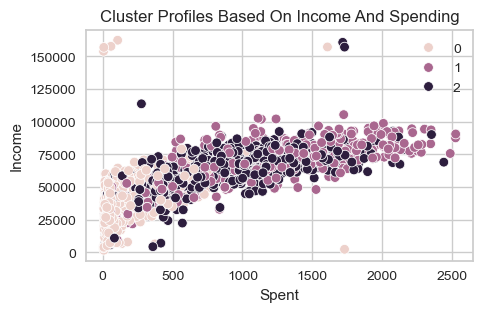

In [150]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["cluster_km_tsne"])
pl.set_title("Cluster Profiles Based On Income And Spending")
plt.legend()
plt.show()

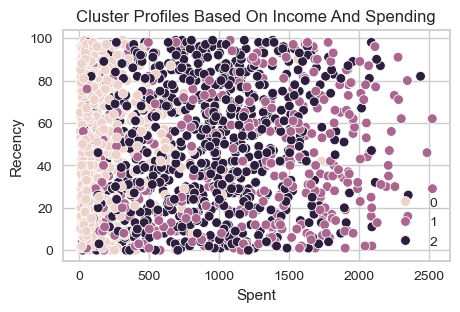

In [151]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Recency"],hue=df["cluster_km_tsne"])
pl.set_title("Cluster Profiles Based On Income And Spending")
plt.legend()
plt.show()


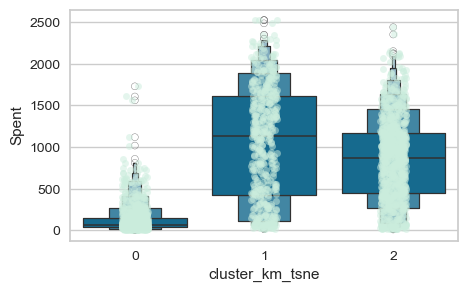

In [152]:
plt.figure()
pl = sns.stripplot(x=df["cluster_km_tsne"], y=df["Spent"], color="#CBEDDD", alpha=0.5)
pl = sns.boxenplot(x=df["cluster_km_tsne"], y=df["Spent"])
plt.show()


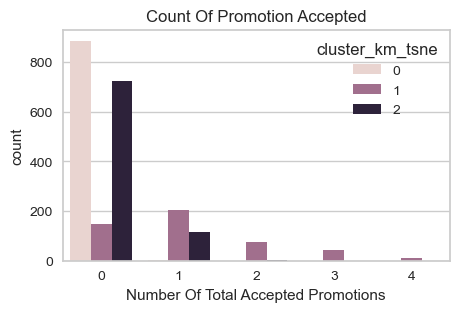

In [153]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["cluster_km_tsne"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

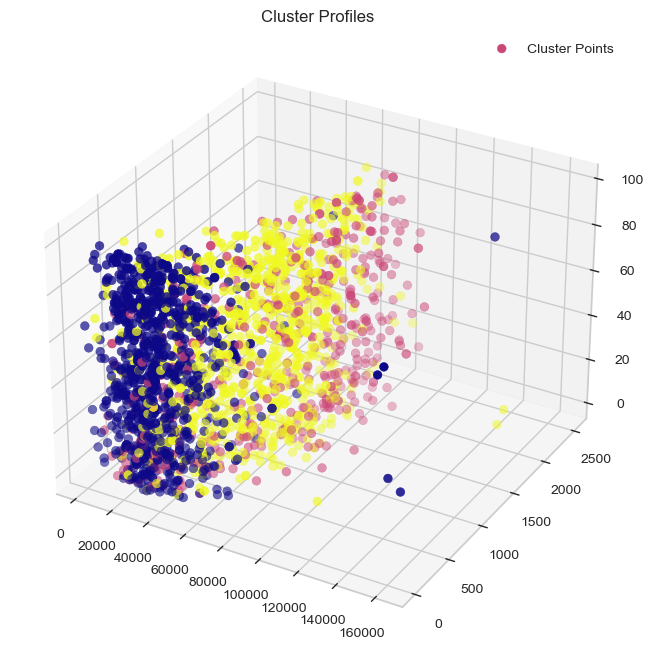

In [154]:
# 3D Plot
x = df["Income"]
y = df["Spent"]
z = df["Recency"]

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")

# Scatter plot with label for the legend
scatter = ax.scatter(x, y, z, s=40, c=df["cluster_km_tsne"], marker='o', cmap='plasma', label="Cluster Points")

# Adding legend and title
ax.legend()
ax.set_title("Cluster Profiles")

# Show the plot
plt.show()
